##1. Exploratory Data Analysis (EDA)

#Load and inspect the data for basic properties (data types, missing values, duplicates).

In [1]:
import pandas as pd

df = pd.read_csv('sensor_data.csv')
df.head()

,timestamp,x_axis_temperature,x_axis_vibration,y_axis_temperature,y_axis_vibration,z_axis_temperature,z_axis_vibration
0,08-01-19 14:41,18.55,0.100,29.05,0.092,18.85,0.128
1,08-01-19 14:41,18.55,0.100,29.25,0.092,18.85,0.132
2,08-01-19 14:41,18.65,0.112,29.05,0.114,18.85,0.132
3,08-01-19 14:41,18.65,0.112,29.25,0.114,18.85,0.110
4,08-01-19 14:41,18.65,0.162,29.05,0.100,18.85,0.110


In [2]:
df.dtypes

,0
timestamp,object
x_axis_temperature,float64
x_axis_vibration,float64
y_axis_temperature,float64
y_axis_vibration,float64
z_axis_temperature,float64
z_axis_vibration,float64


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 7 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   timestamp           1048575 non-null  object 
 1   x_axis_temperature  851967 non-null   float64
 2   x_axis_vibration    851967 non-null   float64
 3   y_axis_temperature  851967 non-null   float64
 4   y_axis_vibration    851967 non-null   float64
 5   z_axis_temperature  851967 non-null   float64
 6   z_axis_vibration    851967 non-null   float64
dtypes: float64(6), object(1)
memory usage: 56.0+ MB


In [4]:
missing_values = df.isnull().sum()
print(missing_values)

timestamp                  0
x_axis_temperature    196608
x_axis_vibration      196608
y_axis_temperature    196608
y_axis_vibration      196608
z_axis_temperature    196608
z_axis_vibration      196608
dtype: int64


checking rows for duplicates would take too long and wouldn't generate an useful insight for the dataset

In [5]:
df.describe()

,x_axis_temperature,x_axis_vibration,y_axis_temperature,y_axis_vibration,z_axis_temperature,z_axis_vibration
count,851967.000000,851967.000000,851967.000000,851967.000000,851967.000000,851967.000000
mean,36.867385,1.014780,19.006035,0.139452,17.708302,0.116789
std,176.659111,7.432032,3.899055,0.254899,2.568081,0.026727
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.650000,0.168000,18.550000,0.130000,18.150000,0.114000
50%,17.650000,0.168000,18.550000,0.130000,18.150000,0.114000
75%,17.650000,0.168000,18.550000,0.130000,18.150000,0.114000
max,1638.350000,65.535000,31.750000,23.732000,22.850000,1.160000


#Visualize the behavior of each sensor over time to identify trends, seasonality, or abrupt changes.

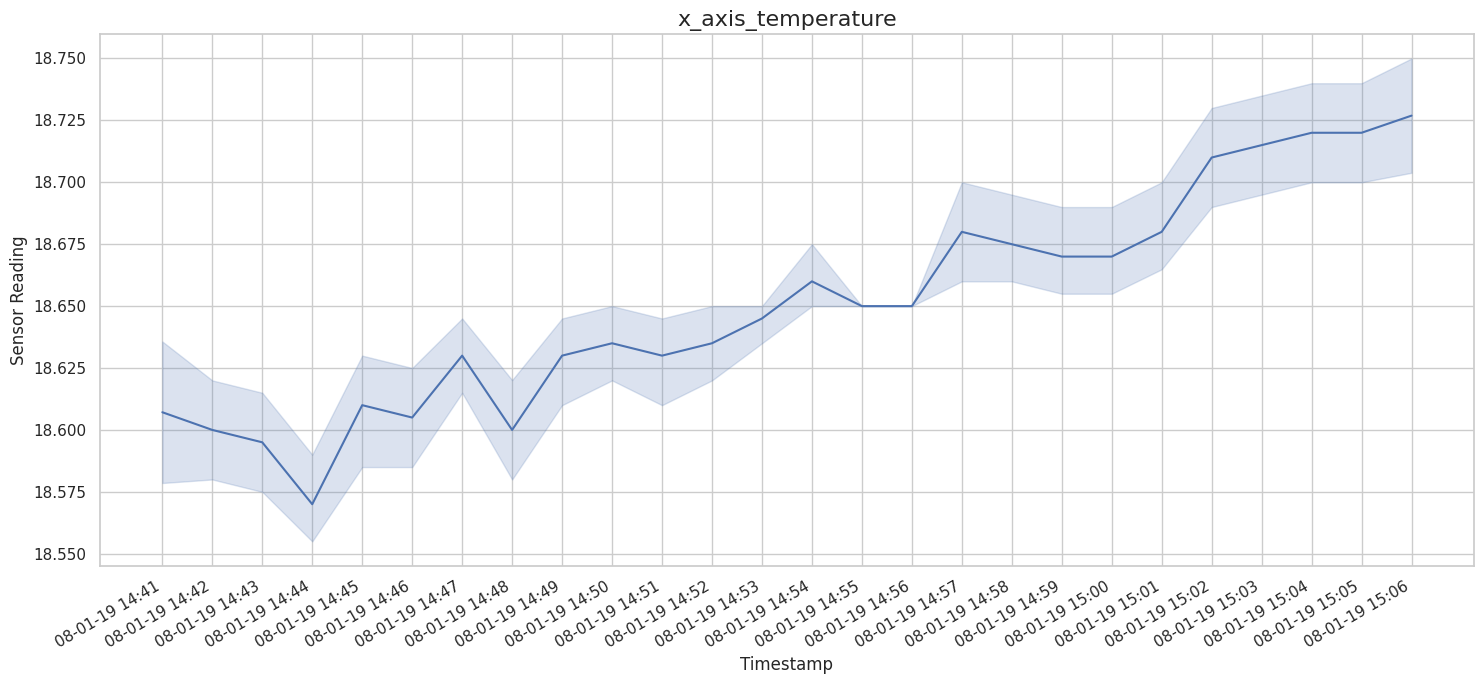

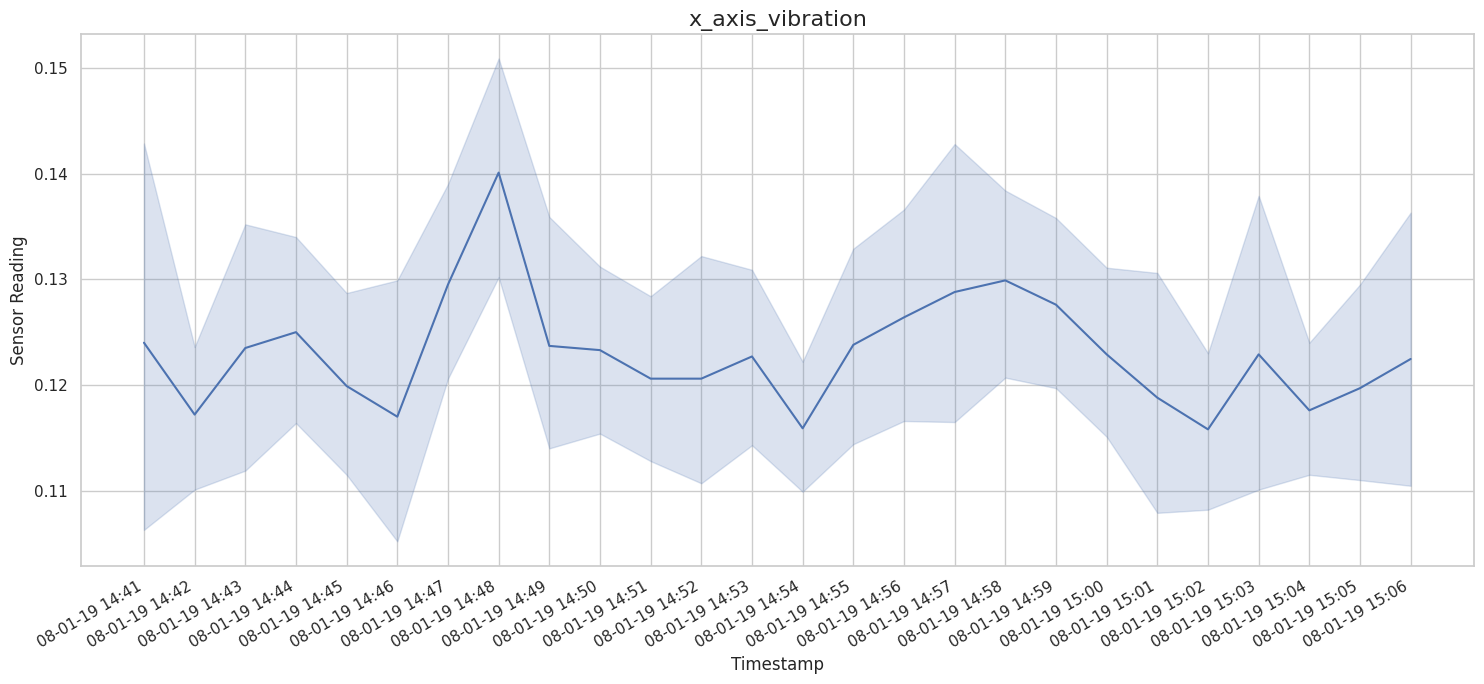

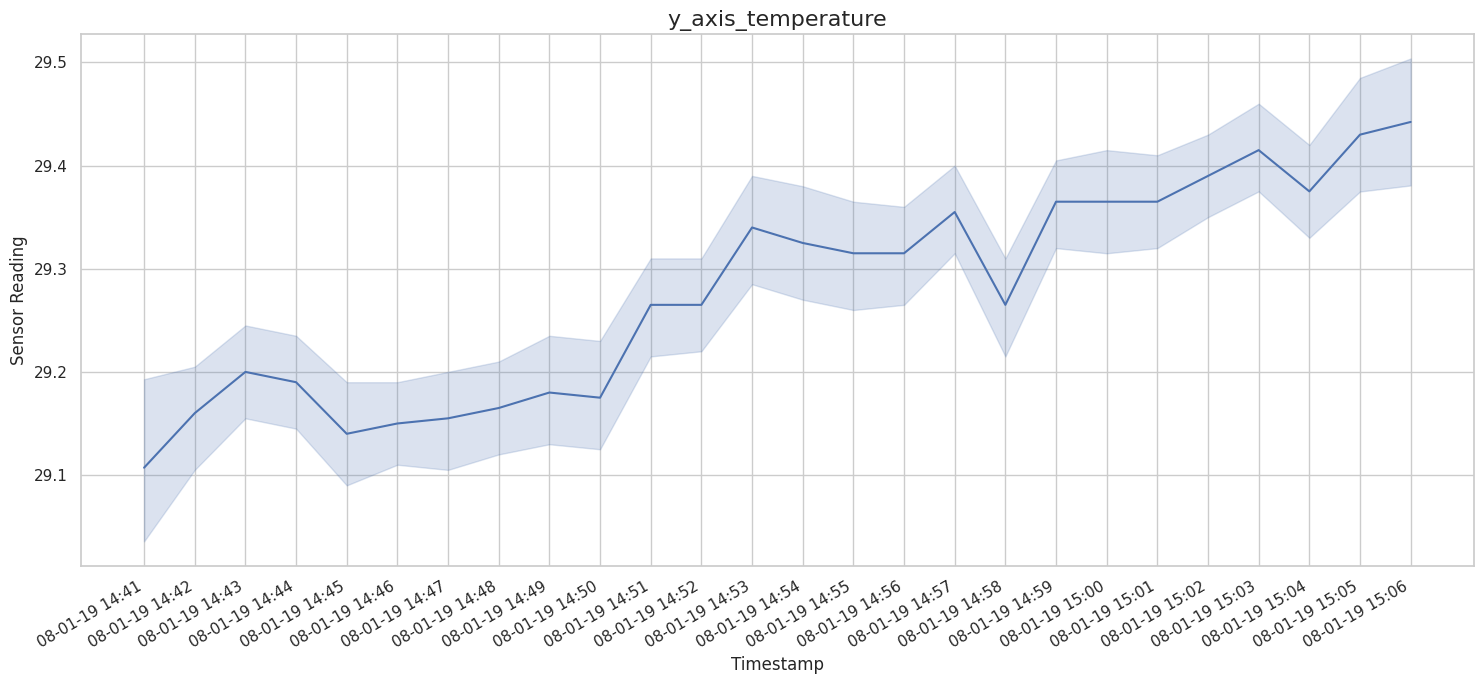

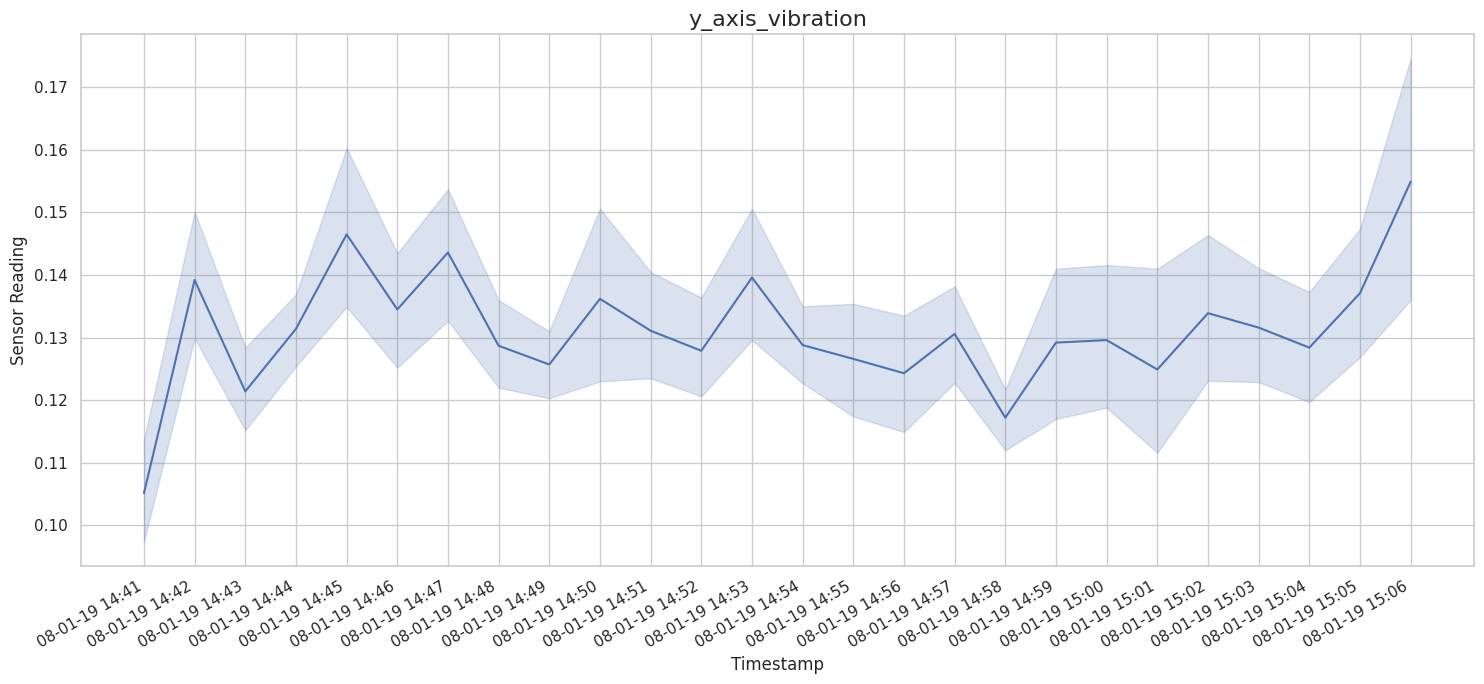

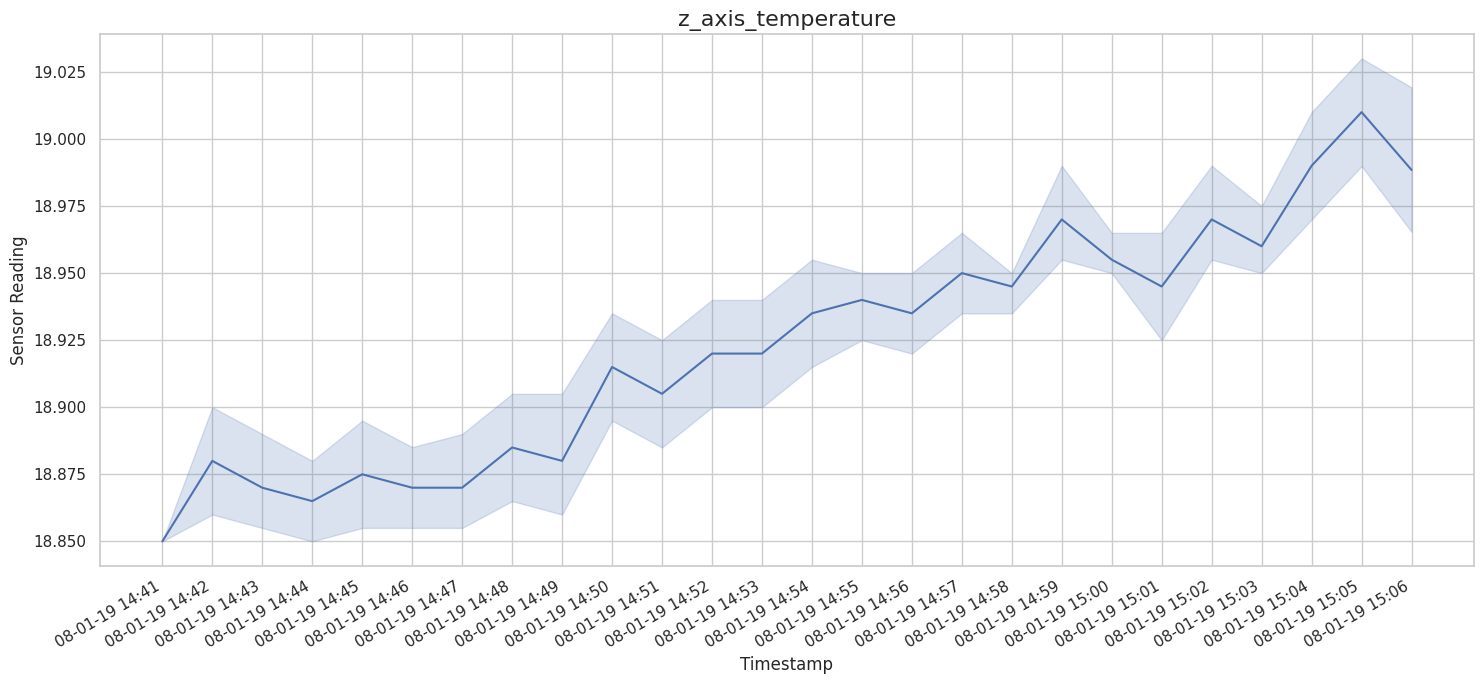

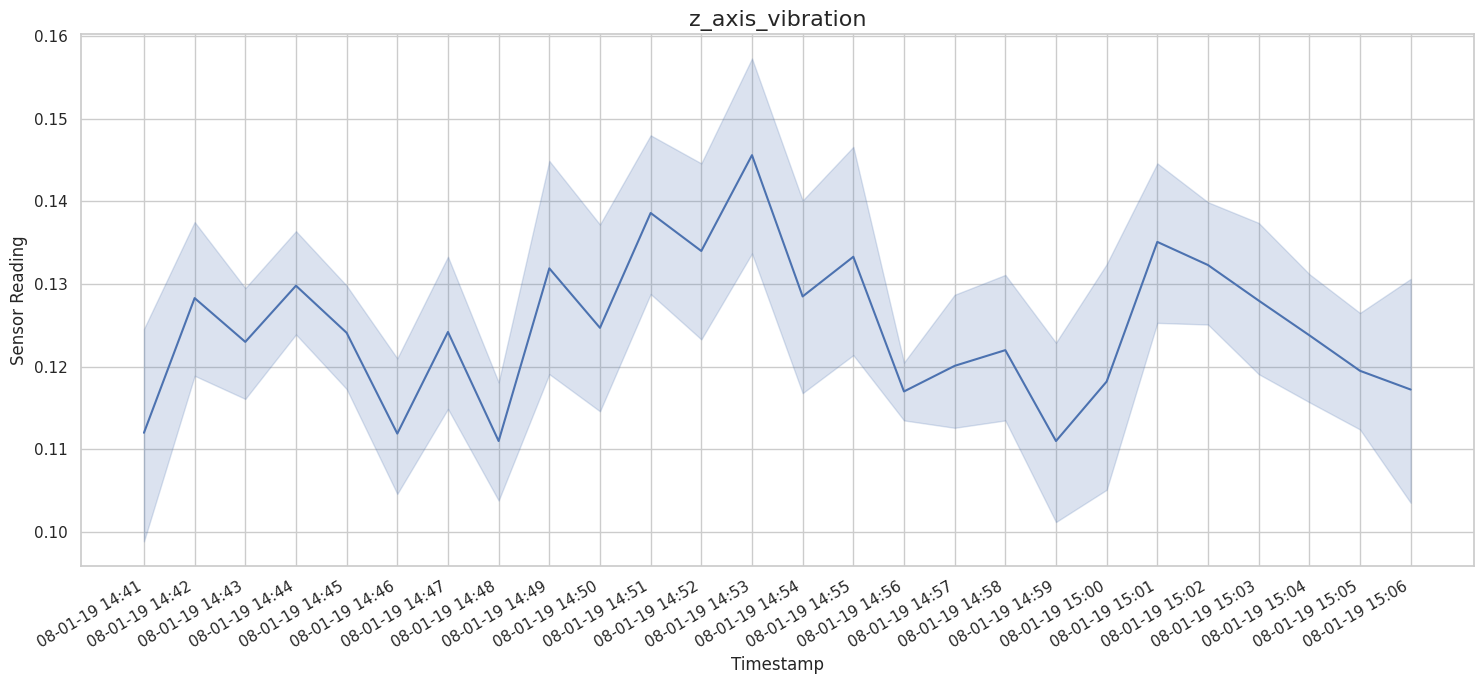

In [6]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_data(df):

    sensor_cols_to_plot = df.select_dtypes(include=np.number).columns.tolist()

    sns.set_theme(style="whitegrid")

    for sensor in sensor_cols_to_plot:
        # Create a new figure for each plot to keep them separate
        plt.figure(figsize=(15, 7))

        # Create the line plot
        ax = sns.lineplot(
            x='timestamp',
            y=sensor,
            data=df
        )

        # Set titles and labels
        ax.set_title(f'{sensor}', fontsize=16)
        ax.set_xlabel('Timestamp', fontsize=12)
        ax.set_ylabel('Sensor Reading', fontsize=12)

        plt.gcf().autofmt_xdate()

        plt.tight_layout()
        plt.show()


df = df.dropna()

plot_data(df[0:500])

#Analyze the distributions of sensor readings to understand their typical ranges and identify potential outliers.

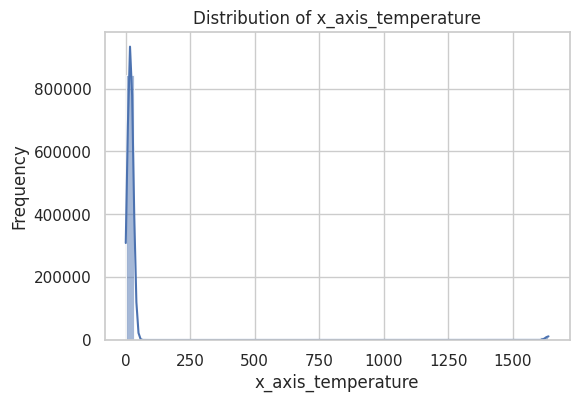

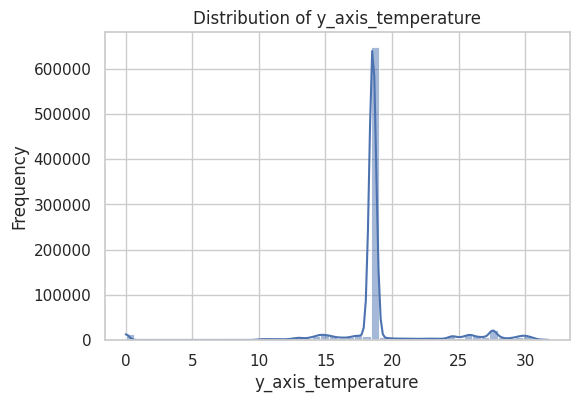

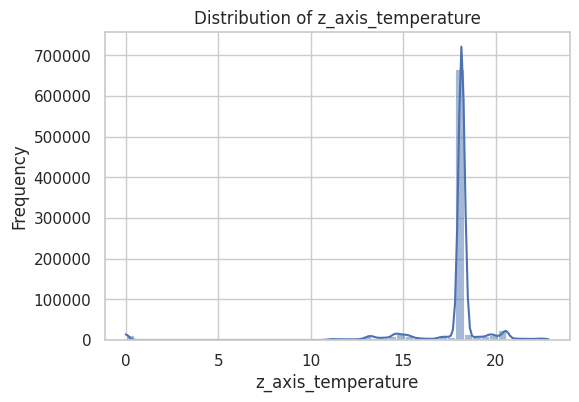

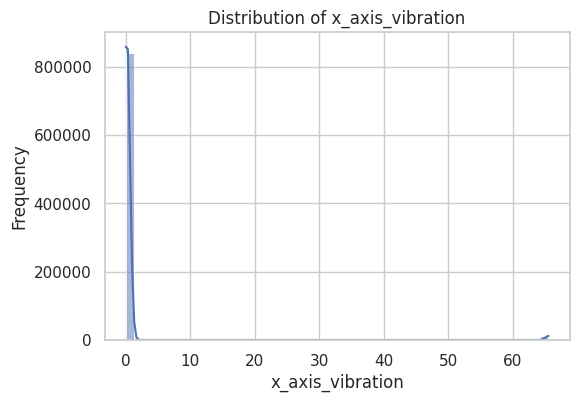

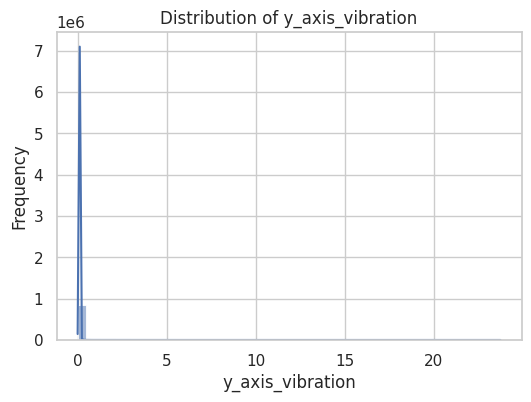

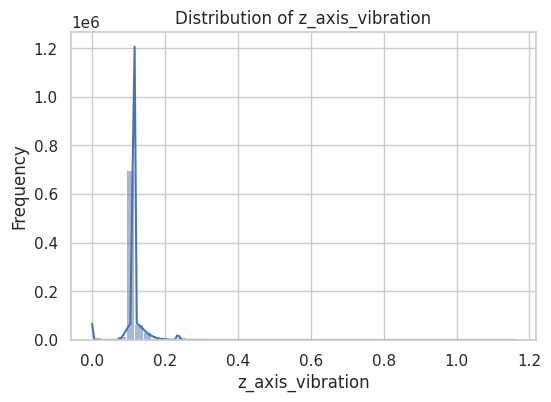

In [7]:
sensor_columns = ["x_axis_temperature", "y_axis_temperature", "z_axis_temperature", 'x_axis_vibration', 'y_axis_vibration', 'z_axis_vibration']  # replace with your real sensor names

# Histograms
for col in sensor_columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=50, kde=True)  # kde=True adds smooth density curve
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

outlier detection

In [8]:
from sklearn.ensemble import IsolationForest

# Sadece sensör kolonlarını seç
sensor_cols = ["x_axis_temperature", "y_axis_temperature", "z_axis_temperature", "x_axis_vibration", "y_axis_vibration", "z_axis_vibration"]
X = df[sensor_cols]

# Modeli tanımla
iso = IsolationForest(contamination=0.01, random_state=42, n_jobs=-1)
df["outlier"] = iso.fit_predict(X)

# outlier=-1 --> anormal, 1 --> normal
outliers = df[df["outlier"] == -1]
print("Outlier count:", len(outliers))

Outlier count: 2414


In [9]:
def show_stats(df, cols, label):
    print(f"\n--- {label} ---")
    print(df[cols].describe(percentiles=[0.01,0.05,0.95,0.99]))

sensor_cols = ["x_axis_temperature", "y_axis_temperature", "z_axis_temperature", "x_axis_vibration", "y_axis_vibration", "z_axis_vibration"]

# Outlier yokken
show_stats(df, sensor_cols, "Whole data set")

# Outlier'lar çıkarıldıktan sonra
clean_df = df[df["outlier"] == 1]
show_stats(clean_df, sensor_cols, "After removing outliers")


--- Whole data set ---
       x_axis_temperature  y_axis_temperature  z_axis_temperature  \
count       851967.000000       851967.000000       851967.000000   
mean            36.867385           19.006035           17.708302   
std            176.659111            3.899055            2.568081   
min              0.000000            0.000000            0.000000   
1%               0.000000            0.000000            0.000000   
5%              14.050000           14.750000           14.350000   
50%             17.650000           18.550000           18.150000   
95%             21.650000           27.550000           19.950000   
99%           1638.350000           30.050000           21.550000   
max           1638.350000           31.750000           22.850000   

       x_axis_vibration  y_axis_vibration  z_axis_vibration  
count     851967.000000     851967.000000     851967.000000  
mean           1.014780          0.139452          0.116789  
std            7.432032       

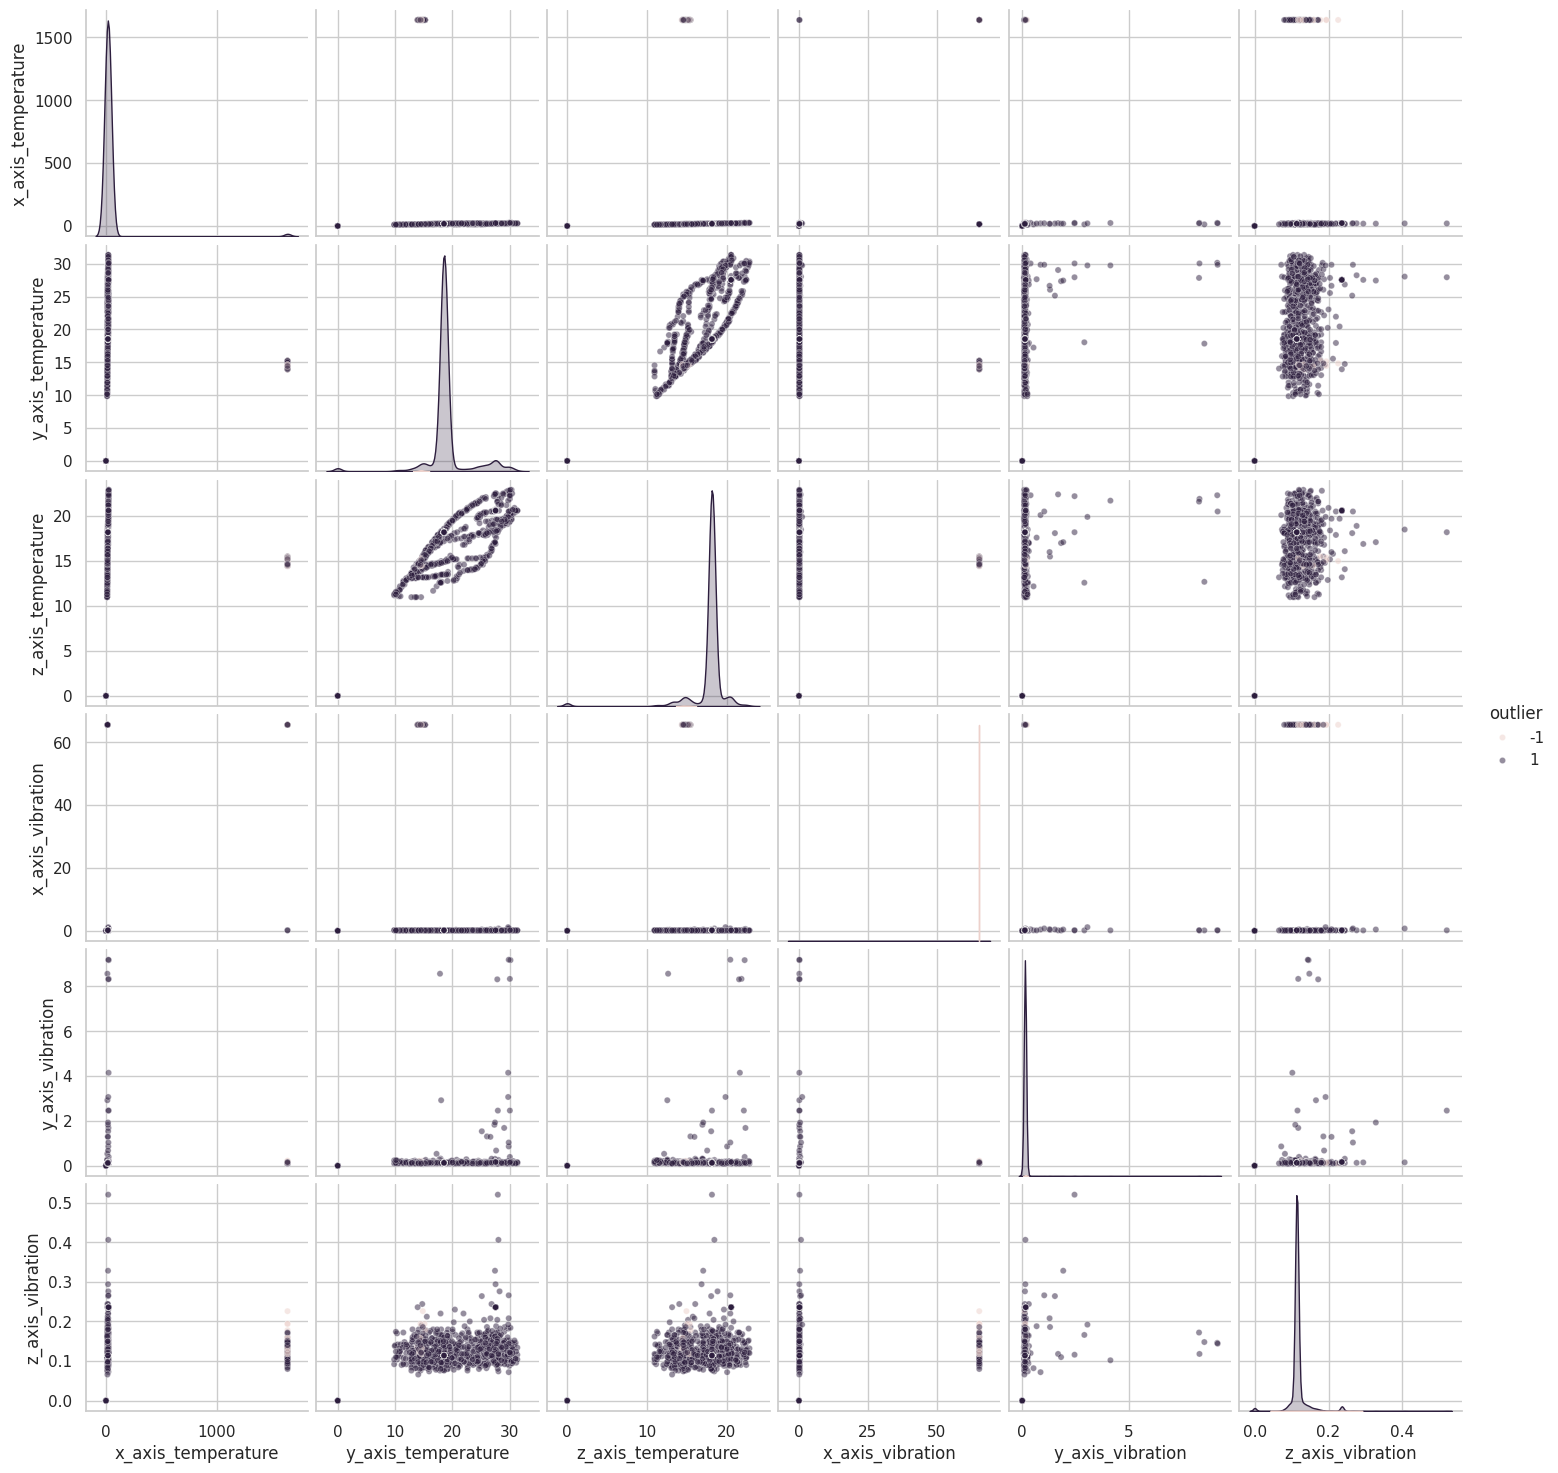

In [10]:
sns.pairplot(
    df.sample(5000),  # büyük veri olduğu için
    vars=["x_axis_temperature","y_axis_temperature","z_axis_temperature",
          "x_axis_vibration","y_axis_vibration","z_axis_vibration"],
    hue="outlier",
    plot_kws={"alpha":0.5, "s":20}
)
plt.show()


In [11]:
df = clean_df
df = df.drop(columns=["outlier"])
df.head()

,timestamp,x_axis_temperature,x_axis_vibration,y_axis_temperature,y_axis_vibration,z_axis_temperature,z_axis_vibration
0,08-01-19 14:41,18.55,0.100,29.05,0.092,18.85,0.128
1,08-01-19 14:41,18.55,0.100,29.25,0.092,18.85,0.132
2,08-01-19 14:41,18.65,0.112,29.05,0.114,18.85,0.132
3,08-01-19 14:41,18.65,0.112,29.25,0.114,18.85,0.110
4,08-01-19 14:41,18.65,0.162,29.05,0.100,18.85,0.110


##2. Data Preprocessing

#Ensure the timestamp column is converted to the correct datetime format.

In [12]:
if 'timestamp' in df.columns: #kod ikinci kez çalıştığında  hata almamak için
        df['timestamp'] = pd.to_datetime(df['timestamp']) # coerce ve format eklenmeli
        df = df.set_index('timestamp')
df.head(5).index.tolist()

/tmp/ipython-input-1885158792.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp']) # coerce ve format eklenmeli


[Timestamp('2019-08-01 14:41:00'),
 Timestamp('2019-08-01 14:41:00'),
 Timestamp('2019-08-01 14:41:00'),
 Timestamp('2019-08-01 14:41:00'),
 Timestamp('2019-08-01 14:41:00')]

#Consider the trade-offs of resampling the data to a lower frequency (e.g., 15-second, 1-minute averages or 1-hour averages). Justify your choice based on whether it reduces noise without losing critical information.

In [13]:
def resampler(df, sec_size):

    resampled_df = df.resample(sec_size).mean()

    num_rows_before = len(df.index)
    num_rows_after = len(resampled_df.index)

    print("Before resample:", num_rows_before)
    print(f"After {sec_size} resample:", num_rows_after)
    print("-" * 27)

    return resampled_df

df_1h = resampler(df, '1h')
df_1m = resampler(df, '1min')
df_15s = resampler(df, '15s')
df_5m = resampler(df, '5min')
df_1M = resampler(df, '1M')
df_80s = resampler(df, '80s')
df_45s = resampler(df, '45s')

Before resample: 849553
After 1h resample: 8040
---------------------------
Before resample: 849553
After 1min resample: 482400
---------------------------
Before resample: 849553
After 15s resample: 1929597
---------------------------
Before resample: 849553
After 5min resample: 96480
---------------------------
Before resample: 849553
After 1M resample: 12
---------------------------


/tmp/ipython-input-3068638435.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_df = df.resample(sec_size).mean()


Before resample: 849553
After 80s resample: 361800
---------------------------
Before resample: 849553
After 45s resample: 643199
---------------------------


Here drawing a graph wouldn't give any meaningful insight so we continued
our analysis with comparing standart deviation values for each sampling.

In [14]:
def analyze_resampling_impact(df, *resampled_dfs):
    """
    Tüm sensörler için resampling etkisini analiz eder
    df: Orijinal dataframe
    *resampled_dfs: Resample edilmiş dataframe'ler (tuple formatında: (df, freq_name))
    """
    sensors = ["x_axis_temperature", "y_axis_temperature", "z_axis_temperature",
               "x_axis_vibration", "y_axis_vibration", "z_axis_vibration"]

    results = {}

    for sensor in sensors:
        try:
            original_std = df[sensor].std()

            resampled_std = {}
            variations = {}

            for resampled_df, freq_name in resampled_dfs:
                std_val = resampled_df[sensor].std()
                resampled_std[freq_name] = std_val
                variation = abs((std_val - original_std) / original_std) * 100
                variations[freq_name] = variation

            results[sensor] = {
                'original_std': original_std,
                'resampled_std': resampled_std,
                'variations': variations
            }

        except KeyError:
            print(f"Uyarı: {sensor} veri çerçevelerde bulunamadı")
            continue

    return results

def print_results(results):
    """
    Detaylı sonuçları yazdırır
    """
    print("=" * 60)
    print("TÜM SENSÖRLER İÇİN RESAMPLING ANALİZİ")
    print("=" * 60)

    for sensor, data in results.items():
        print(f"\n🔹 {sensor}:")
        print(f"   Orijinal STD: {data['original_std']:.4f}")
        for freq_name, std_val in data['resampled_std'].items():
            variation = data['variations'][freq_name]
            print(f"   {freq_name}: {std_val:.4f} (%{variation:.2f} değişim)")

def print_summary_statistics(results):
    """
    Özet istatistikleri yazdırır
    """
    if not results:
        print("Sonuç bulunamadı!")
        return

    print("\n" + "=" * 60)
    print("ÖZET İSTATİSTİKLER - ORTALAMA DEĞİŞİMLER")
    print("=" * 60)

    # Tüm frekansları topla
    all_freqs = set()
    for sensor_data in results.values():
        all_freqs.update(sensor_data['variations'].keys())

    # Her frekans için ortalama değişim
    avg_variations = {freq: 0 for freq in all_freqs}
    count = len(results)

    for sensor_data in results.values():
        for freq, variation in sensor_data['variations'].items():
            avg_variations[freq] += variation

    for freq in avg_variations:
        avg_variations[freq] /= count

    print(f"\nOrtalama STD Değişimi:")
    for freq, avg_var in avg_variations.items():
        print(f"   {freq}: %{avg_var:.2f}")


# Fonksiyonları kullanma örneği
# İstediğiniz resample edilmiş dataframe'leri gönderebilirsiniz
results = analyze_resampling_impact(
    df,
    (df_15s, '15s'),
    (df_45s, '45s'),
    (df_1m, '1min'),
    (df_80s, '80s'),
    (df_5m, '5min'),
    (df_1h, '1h'),
    (df_1M, '1M')
)

# Detaylı sonuçları göster
print_results(results)

# Özet istatistikleri göster
print_summary_statistics(results)

# Ek olarak: Her sensör için en iyi frekansı göster
print("\n" + "=" * 60)
print("HER SENSÖR İÇİN EN İYİ FREKANS")
print("=" * 60)

for sensor, data in results.items():
    if data['variations']:
        best_freq = min(data['variations'].items(), key=lambda x: x[1])
        print(f"{sensor}: {best_freq[0]} (%{best_freq[1]:.2f} değişimle)")

TÜM SENSÖRLER İÇİN RESAMPLING ANALİZİ

🔹 x_axis_temperature:
   Orijinal STD: 155.7233
   15s: 142.0054 (%8.81 değişim)
   45s: 142.0054 (%8.81 değişim)
   1min: 142.0054 (%8.81 değişim)
   80s: 141.5715 (%9.09 değişim)
   5min: 139.9393 (%10.14 değişim)
   1h: 134.2950 (%13.76 değişim)
   1M: 15.5090 (%90.04 değişim)

🔹 y_axis_temperature:
   Orijinal STD: 3.8967
   15s: 3.9007 (%0.10 değişim)
   45s: 3.9007 (%0.10 değişim)
   1min: 3.9007 (%0.10 değişim)
   80s: 3.9020 (%0.14 değişim)
   5min: 3.9112 (%0.37 değişim)
   1h: 3.9822 (%2.19 değişim)
   1M: 1.4128 (%63.74 değişim)

🔹 z_axis_temperature:
   Orijinal STD: 2.5671
   15s: 2.5711 (%0.16 değişim)
   45s: 2.5711 (%0.16 değişim)
   1min: 2.5711 (%0.16 değişim)
   80s: 2.5726 (%0.22 değişim)
   5min: 2.5850 (%0.70 değişim)
   1h: 2.6864 (%4.65 değişim)
   1M: 0.7578 (%70.48 değişim)

🔹 x_axis_vibration:
   Orijinal STD: 6.6297
   15s: 6.2737 (%5.37 değişim)
   45s: 6.2737 (%5.37 değişim)
   1min: 6.2737 (%5.37 değişim)
   80s: 6.2

By looking at these results we can conclude that optimal choice would be to resample with 1 minute.

#Apply appropriate scaling to the sensor data. Research different scaling techniques (e.g., MinMaxScaler, StandardScaler) and determine which is most suitable for the models you plan to test.

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_array = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_array, columns=df.columns, index=df.index)

print(scaled_df.head())

                     x_axis_temperature  x_axis_vibration  y_axis_temperature  \
timestamp                                                                       
2019-08-01 14:41:00           -0.089457         -0.111315            2.574694   
2019-08-01 14:41:00           -0.089457         -0.111315            2.626019   
2019-08-01 14:41:00           -0.088815         -0.109505            2.574694   
2019-08-01 14:41:00           -0.088815         -0.109505            2.626019   
2019-08-01 14:41:00           -0.088815         -0.101963            2.574694   

                     y_axis_vibration  z_axis_temperature  z_axis_vibration  
timestamp                                                                    
2019-08-01 14:41:00         -0.188670            0.441813          0.426402  
2019-08-01 14:41:00         -0.188670            0.441813          0.577747  
2019-08-01 14:41:00         -0.100357            0.441813          0.577747  
2019-08-01 14:41:00         -0.100357     

First, outliers in the dataset were removed. Then, since the sensor features had different scales and variances, they were normalized using StandardScaler. This ensured all features have a mean of 0 and a standard deviation of 1, optimizing the performance of the anomaly detection and RUL prediction models.

In [16]:
print("Now we print standard deviation and mean values for each column to make sure it worked accordingly.")
print()
print("Standard deviation:")
print(scaled_df.std().round(2)) # We rounded these values to have a clearer output.
print()
print("Mean:")
print(scaled_df.mean().round(2))

Now we print standard deviation and mean values for each column to make sure it worked accordingly.

Standard deviation:
x_axis_temperature    1.0
x_axis_vibration      1.0
y_axis_temperature    1.0
y_axis_vibration      1.0
z_axis_temperature    1.0
z_axis_vibration      1.0
dtype: float64

Mean:
x_axis_temperature   -0.0
x_axis_vibration     -0.0
y_axis_temperature    0.0
y_axis_vibration     -0.0
z_axis_temperature   -0.0
z_axis_vibration     -0.0
dtype: float64


In [17]:
df = scaled_df

Now original df equals the scaled one.

##3. Feature Engineering


#Lag Features: Create features that represent the state of the machine at past time steps.

In [18]:
def add_lag_features(df, cols, lags):
    """
    Belirtilen kolonlara geçmiş adımları (lag) ekler.

    df: DataFrame (datetime index'li olmalı)
    cols: hangi kolonlar için lag eklenecek
    lags: [1, 2, 3] gibi, kaç adım geriye bakılacağı

    """
    for col in cols:
        for lag in lags:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
    return df


sensor_cols = ["x_axis_temperature", "y_axis_temperature", "z_axis_temperature",
               "x_axis_vibration", "y_axis_vibration", "z_axis_vibration"]

df = add_lag_features(df, sensor_cols, lags=[1, 2, 3])
print(df.head())

                     x_axis_temperature  x_axis_vibration  y_axis_temperature  \
timestamp                                                                       
2019-08-01 14:41:00           -0.089457         -0.111315            2.574694   
2019-08-01 14:41:00           -0.089457         -0.111315            2.626019   
2019-08-01 14:41:00           -0.088815         -0.109505            2.574694   
2019-08-01 14:41:00           -0.088815         -0.109505            2.626019   
2019-08-01 14:41:00           -0.088815         -0.101963            2.574694   

                     y_axis_vibration  z_axis_temperature  z_axis_vibration  \
timestamp                                                                     
2019-08-01 14:41:00         -0.188670            0.441813          0.426402   
2019-08-01 14:41:00         -0.188670            0.441813          0.577747   
2019-08-01 14:41:00         -0.100357            0.441813          0.577747   
2019-08-01 14:41:00         -0.100357

Thanks to lag features, model will not only be able to see the current reading but also the trend in previous steps. Therefore increasing the learning capacity.

In [19]:
df = df.dropna()

Since we have a big dataset it is okay to lose few values.

#Rolling Window Features: Calculate statistics (e.g., moving average, standard deviation) over a defined time window to capture the machine's recent behavior and volatility.

In [24]:
def add_rolling_features(df, window_size=3, period =3):
    """
    DataFrame'e rolling mean ve rolling std kolonlarını ekler.

    Args:
        df (pd.DataFrame): Orijinal DataFrame
        window_size (int): Rolling window boyutu

    Returns:
        pd.DataFrame: Yeni kolonlar eklenmiş DataFrame
    """
    new_cols = {}

    for col in df.columns:
        if df[col].dtype in [float, int]:
            new_cols[f"{col}_roll_mean"] = df[col].rolling(window=window_size, min_periods = period).mean()
            new_cols[f"{col}_roll_std"] = df[col].rolling(window=window_size, min_periods = period).std()

    return pd.concat([df, pd.DataFrame(new_cols, index=df.index)], axis=1)

print(add_rolling_features(df, 3, 3))

                     x_axis_temperature  x_axis_vibration  y_axis_temperature  \
timestamp                                                                       
2019-08-01 14:41:00           -0.088815         -0.109505            2.626019   
2019-08-01 14:41:00           -0.088815         -0.101963            2.574694   
2019-08-01 14:41:00           -0.089457         -0.101963            2.600357   
2019-08-01 14:41:00           -0.088815         -0.108298            2.549032   
2019-08-01 14:42:00           -0.089457         -0.108298            2.626019   
...                                 ...               ...                 ...   
2019-02-18 21:10:00           -0.095237         -0.101058           -0.119876   
2019-02-18 21:11:00           -0.095237         -0.101058           -0.119876   
2019-02-18 21:11:00           -0.095237         -0.101058           -0.119876   
2019-02-18 21:11:00           -0.095237         -0.101058           -0.119876   
2019-02-18 21:11:00         

#Aggregate Features: Engineer features that summarize the overall state of the machine, such as the average temperature or the magnitude of the vibration vector.


##4. Unsupervised Anomaly Detection

##5. Remaining Useful Life (RUL) Modeling and Training

##6. Hyperparameter Tuning

##7. Test and Evaluation